Proyecto de Procesado de Datos

In [1]:
#Importamos librerias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns

df = pd.read_csv("/workspaces/Data-Preprocessing-Project-Vicente-Polo/data/raw/AB_NYC_2019.csv").iloc[:,1:]

pd.set_option('display.max_columns', None)

df.head()


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Comprobamos columnas y filas para hacer una estimación del tamaño de los valores

In [3]:
df.shape

(48895, 15)

Comprobamos el tipo de las columnas para establecer una idea de las categóricas

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month               

Análisis de constantes

In [ ]:
n_unicos = df.nunique()
n_unicos

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

Revisamos que no hay duplicados

In [ ]:
df.duplicated().sum()

np.int64(0)

Comprobamos las columnas con datos faltantes

<Axes: >

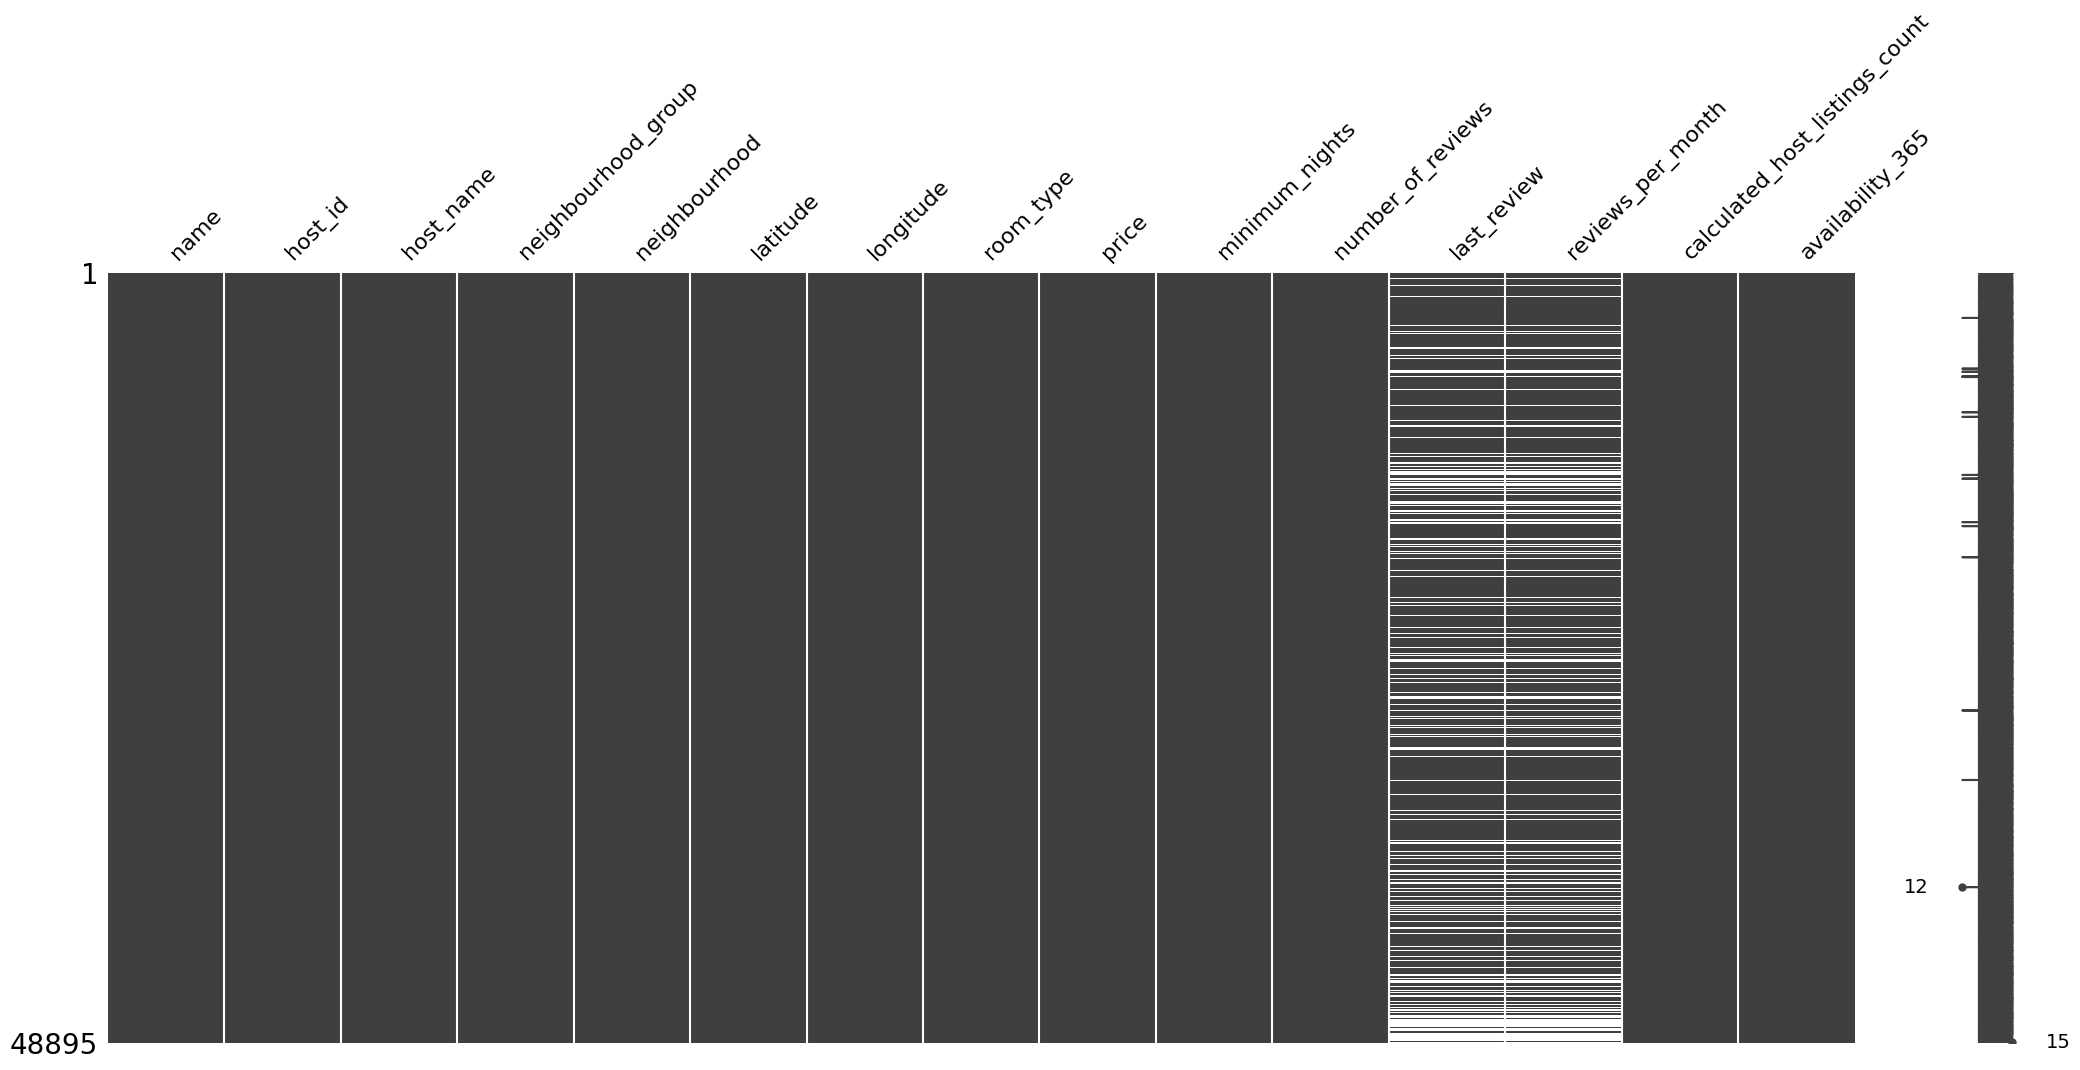

In [4]:
msno.matrix(df)

In [5]:
# Comprobamos numéricamente el porcentaje de valores faltantes en las diferentes columnas
df.isnull().mean()*100


name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

Como se puede comprobar los campos correspondientes a reviews tienen un 20 por ciento de valores faltantes, por lo que estimamos que deberían ser eliminadas. Así como name y host_name a los cuales les faltan valores y son categóricas. 

In [6]:
#Eliminamos columnas con 20% de nulos
df.drop(["name", "host_name", "last_review", "reviews_per_month"],axis=1,inplace=True)


In [7]:
#Procedemos a comprobar si aún quedan datos faltantes

df.isnull().any(axis=1).mean()*100

np.float64(0.0)

Rellenar datos usando el algoritmo knn para imputar valores. 

In [8]:

#Seleccionar solo columnas numéricas
columnas_numericas = df.select_dtypes(include=['number'])
columnas_no_numericas = df.select_dtypes(exclude=['number'])

# Aplicar KNNImputer solo a las columnas numéricas
imputador_knn = KNNImputer(n_neighbors=3)
df_imputado_num = pd.DataFrame(imputador_knn.fit_transform(columnas_numericas),columns=columnas_numericas.columns)
    


Comprobamos si quedan valores que se salgan (Si imputasemos que no es el caso)

In [9]:
df_imputado_num.isnull().mean()*100


host_id                           0.0
latitude                          0.0
longitude                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

# Identificar correlaciones mediante heatmap

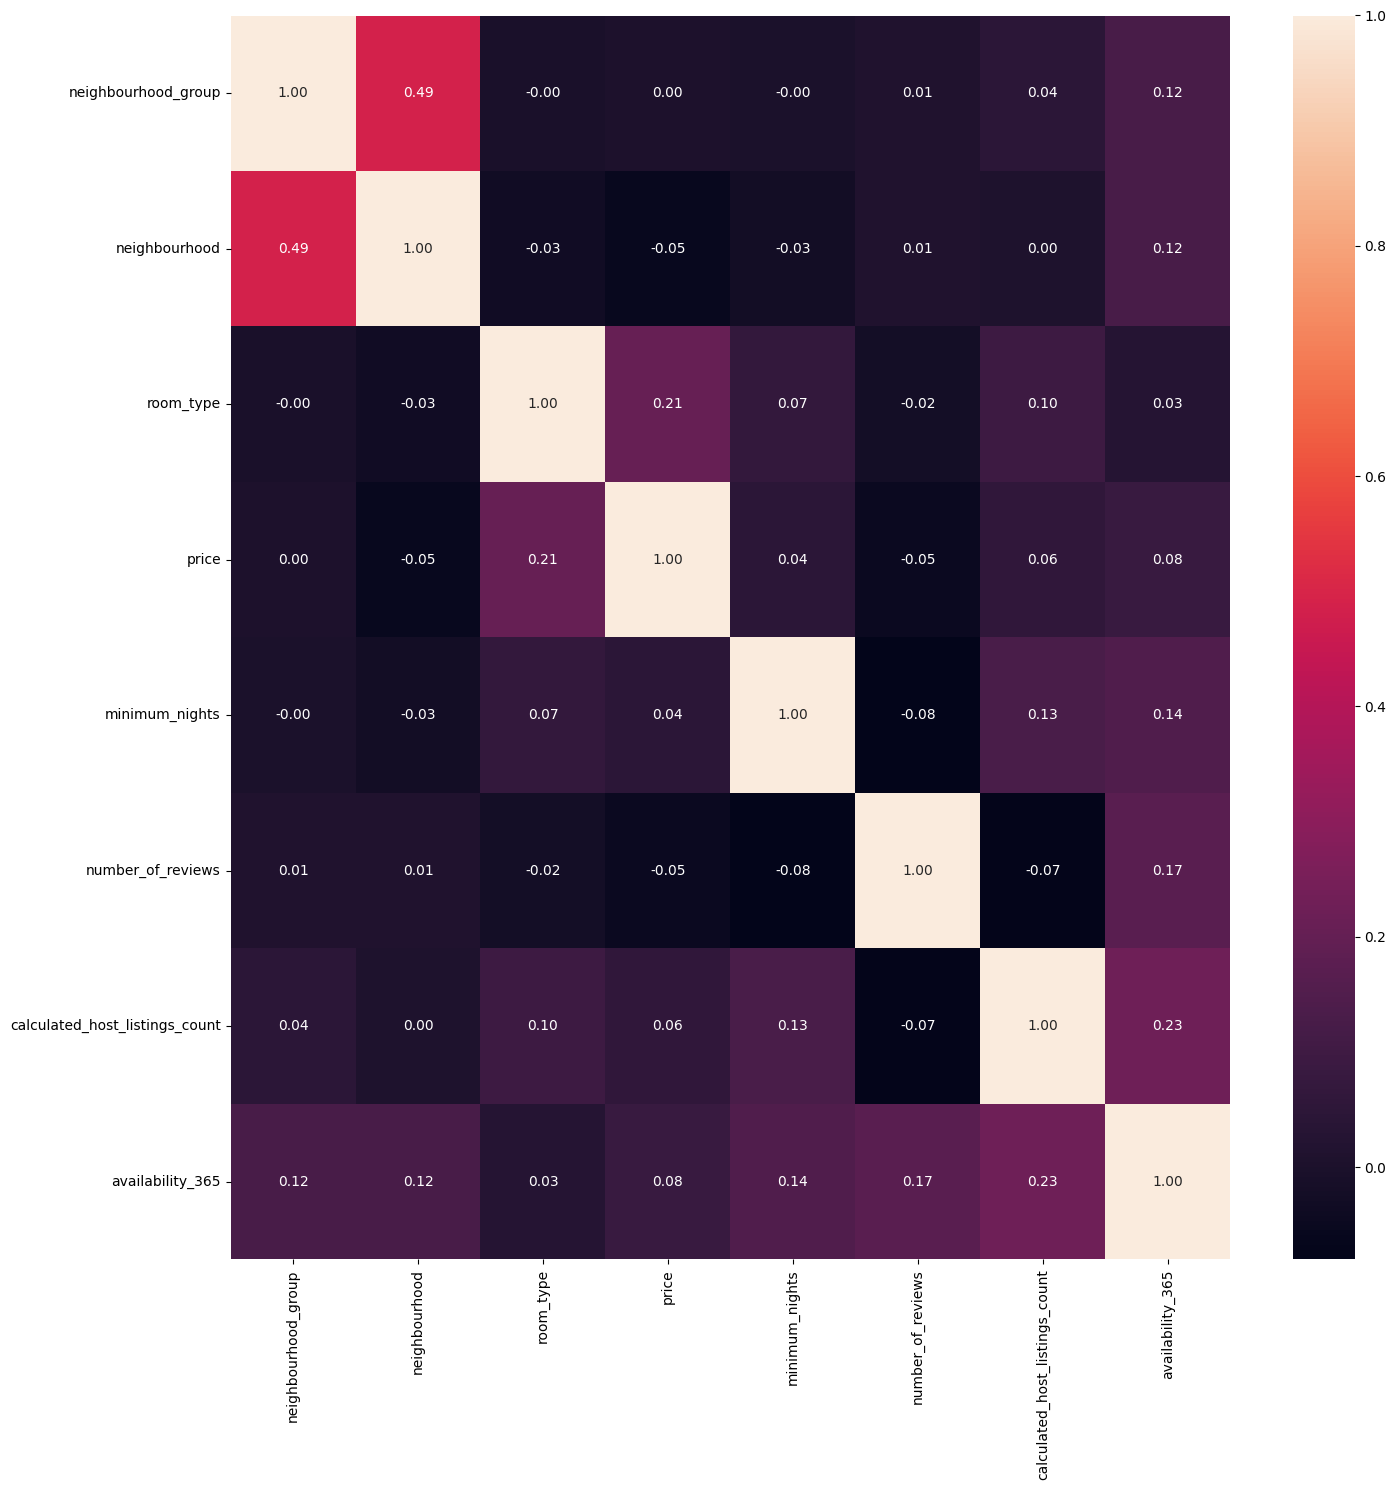

In [10]:
df["room_type"] = pd.factorize(df["room_type"])[0]
df["neighbourhood_group"] = pd.factorize(df["neighbourhood_group"])[0]
df["neighbourhood"] = pd.factorize(df["neighbourhood"])[0]

fig, axes = plt.subplots(figsize=(15, 15))

sns.heatmap(df[["neighbourhood_group", "neighbourhood", "room_type", "price", "minimum_nights",	
                        "number_of_reviews", "calculated_host_listings_count", "availability_365"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

# Draw Plot
plt.show()

Así a primera vista, excepto el neighbourhood y neighbourhood_group, no existe una correlación muy marcada entre las diferentes variables

# Identificar observaciones influyentes

In [11]:
# Separamos las variables independientes de la dependiente
X = df.drop(['price'], axis=1)
y = df['price']

# Ajusta un modelo de regresión lineal
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

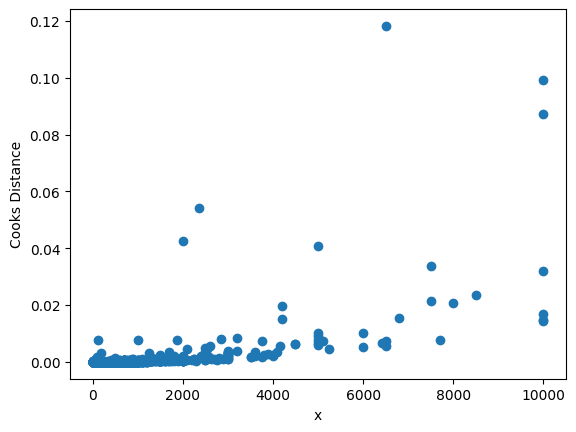

In [12]:
plt.scatter(df.price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [14]:
# Punto de corte para la distancia de cook
pto_corte = 4/len(df)

# Viviendas por encima del pto de corte
len(np.where(cooks_distance[0]>pto_corte)[0])

700

In [15]:

ind_cook = np.where(cooks_distance[0] > 0.05)[0]
print(f"Observaciones con distancia de Cook > 0.5: {len(ind_cook)}") 

# Mostrar los índices si son pocos
if len(ind_cook) > 0:
    print(f"Índices con distancia de Cook > 0.5: {ind_cook}")

Observaciones con distancia de Cook > 0.5: 4
Índices con distancia de Cook > 0.5: [ 9151 12342 17811 48043]


Eliminamos los valores que exceden el punto de corte sugerido

In [16]:
df = df.drop(np.where(cooks_distance[0]>pto_corte)[0])

# Definimos X e Y para dividir el data set entre train y test

In [17]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)